In [1]:
# Importing necessary libraries

import os
import pickle
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Scikit-learn modules for machine learning and data processing
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scienceplots

from pprint import pprint

from src.utils import *


In [2]:
# Set random seed for reproducibility
random.seed(32)  # Sets the seed for Python's built-in random library to ensure consistent random results
np.random.seed(32)  # Sets the seed for NumPy's random number generator for consistent results in NumPy operations

# Manage environment variables for LaTeX integration in plots
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'  # Adds the LaTeX binary path to the system PATH on MacOS for rendering plots with LaTeX formatting

# Define a neighborhood size parameter for line drawing
neighbor_size = 2  # Interval or step size for selecting points when drawing a line

# Define folder paths for data and plots
data_folder = './data/'  # Folder path where input data files are stored
img_folder = './plots/'  # Folder path where output plots will be saved
model_folder = './models/'  # Folder path where model weights will be saved

step_lengths = [5, 10, 15, 20] 

results_all = {} # Store GPR preformance metrics

In [3]:
pprint(list_files(data_folder))

['BN-C60.txt',
 'BN-F-C60.txt',
 'BN-F-C60-C1.txt',
 'BN-F-C60-C2.txt',
 'BN-F-C60-A1.txt',
 'BN-F-C60-T1.txt',
 'BN-F-C60-A2.txt',
 'BN-F-C60-T2.txt',
 'BN-F-C60-G2.txt',
 'BN-F-C60-G1.txt',
 'C60.txt']


In [4]:
datasets = [
    'C60.txt',
    'BN-C60.txt',
    'BN-F-C60.txt',
    'BN-F-C60-A1.txt',
    'BN-F-C60-A2.txt',
    'BN-F-C60-C1.txt',
    'BN-F-C60-C2.txt',
    'BN-F-C60-G1.txt',
    'BN-F-C60-G2.txt',
    'BN-F-C60-T1.txt',
    'BN-F-C60-T2.txt',
]

In [5]:
data_all = read_datasets(data_folder, datasets)

C60.txt
BN-C60.txt
BN-F-C60.txt
BN-F-C60-A1.txt
BN-F-C60-A2.txt
BN-F-C60-C1.txt
BN-F-C60-C2.txt
BN-F-C60-G1.txt
BN-F-C60-G2.txt
BN-F-C60-T1.txt
BN-F-C60-T2.txt


In [6]:
pprint(list(data_all.keys()))

['C60',
 'BN-C60',
 'BN-F-C60',
 'BN-F-C60-A1',
 'BN-F-C60-A2',
 'BN-F-C60-C1',
 'BN-F-C60-C2',
 'BN-F-C60-G1',
 'BN-F-C60-G2',
 'BN-F-C60-T1',
 'BN-F-C60-T2']


In [7]:
print("Stat for Energy Values")

print(f"{'Dataset':<20}{'# of Points':<15}{'Min':<10}{'Max':<10}")
print("="*60)

# Print formatted data
for key in data_all:
    data = data_all[key]
    print(f"{key:<20}{data.shape[0]:<15}{np.min(data[:,0]):<10}{np.max(data[:,0]):<10}")

Stat for Energy Values
Dataset             # of Points    Min       Max       
C60                 400            100.0     898.0     
BN-C60              340            100.0     3490.0    
BN-F-C60            350            100.0     4986.0    
BN-F-C60-A1         350            100.0     4986.0    
BN-F-C60-A2         306            104.0     4984.0    
BN-F-C60-C1         306            104.0     4984.0    
BN-F-C60-C2         306            104.0     4984.0    
BN-F-C60-G1         328            96.0      5982.0    
BN-F-C60-G2         328            96.0      5982.0    
BN-F-C60-T1         350            100.0     4986.0    
BN-F-C60-T2         306            104.0     4984.0    


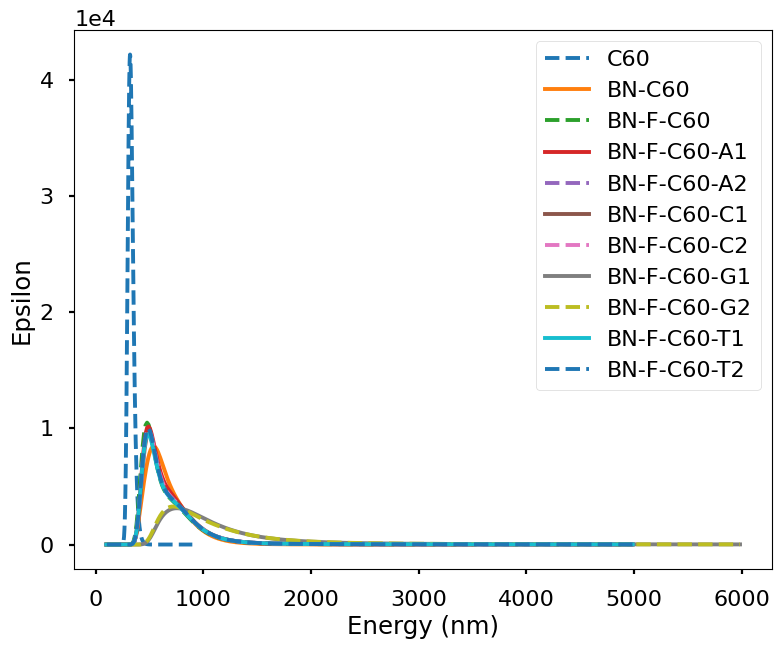

In [8]:
plt.style.use('seaborn-v0_8-poster')
plt.figure(figsize=(9, 7))
# Apply formatter to the y-axis
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))

i = 0
for key in data_all:
    data = data_all[key]
    if i % 2 == 0:
        plt.plot(data[:,0], data[:,1], '--', label=key) 
    else:
        plt.plot(data[:,0], data[:,1], '-', label=key) 
    i = i + 1
    
plt.xlabel('Energy (nm)')
plt.ylabel('Epsilon')
plt.legend()
plt.savefig(img_folder+'/energy_nm.png', bbox_inches='tight')
plt.show()
plt.close()

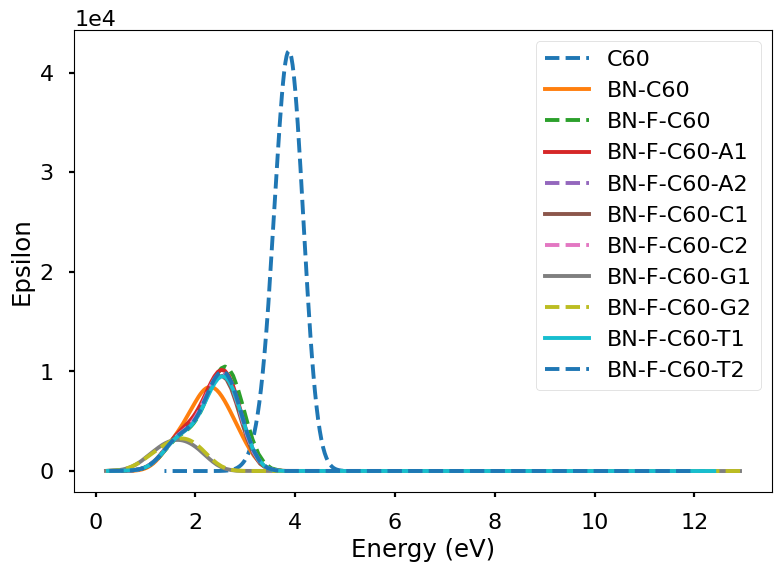

In [9]:
plt.style.use('seaborn-v0_8-poster')
plt.figure(figsize=(9, 6))
# Apply formatter to the y-axis
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))

i = 0
for key in data_all:
    data = data_all[key]
    if i % 2 == 0:
        plt.plot(1240/data[:,0], data[:,1], '--', label=key) 
    else:
        plt.plot(1240/data[:,0], data[:,1], '-', label=key) 
    i = i + 1

plt.xlabel('Energy (eV)')
plt.ylabel('Epsilon')
plt.legend()
plt.savefig(img_folder+'/energy_eV.png', bbox_inches='tight')
plt.show()
plt.close()

## Calculate Optical Bandgaps

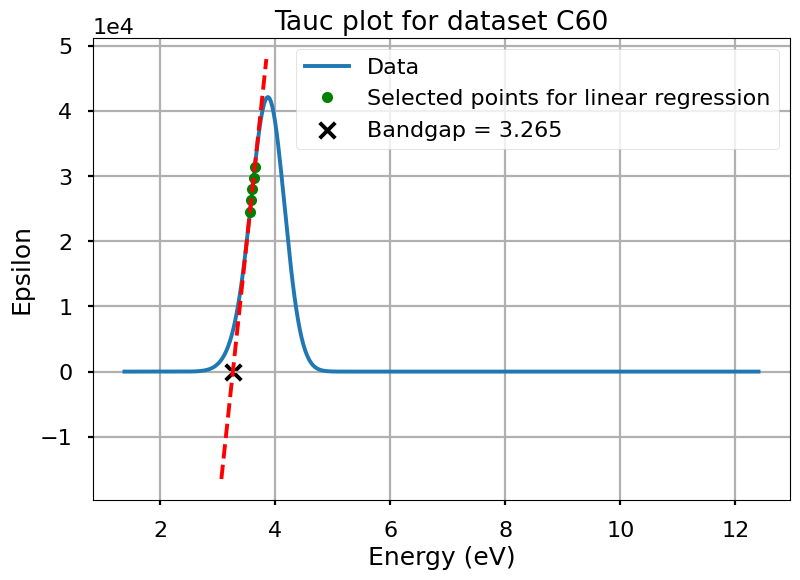

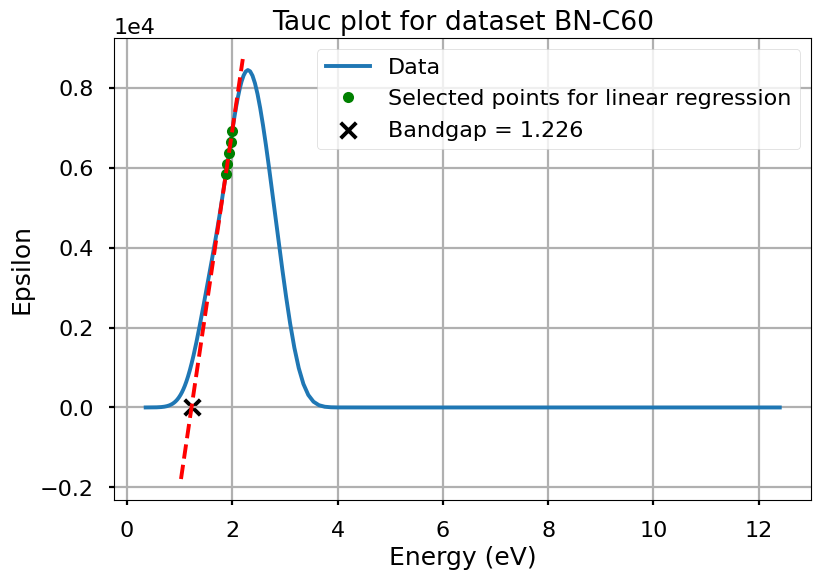

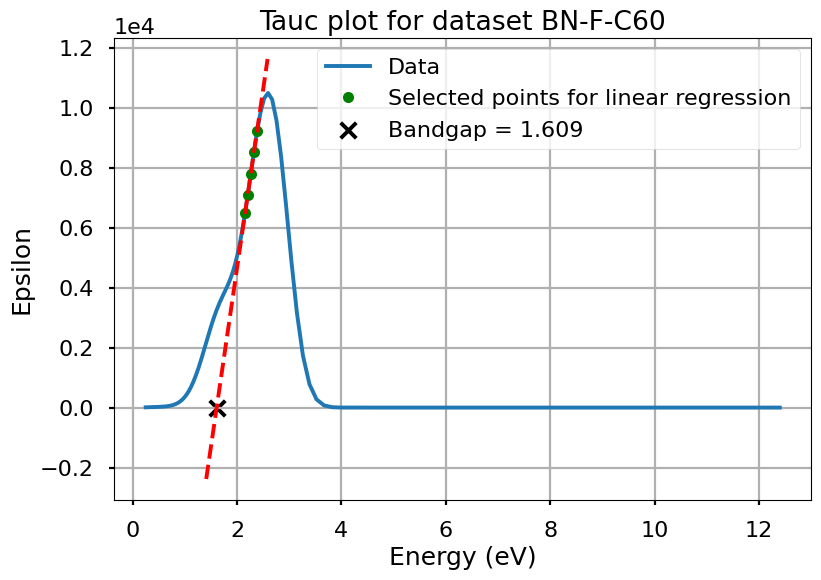

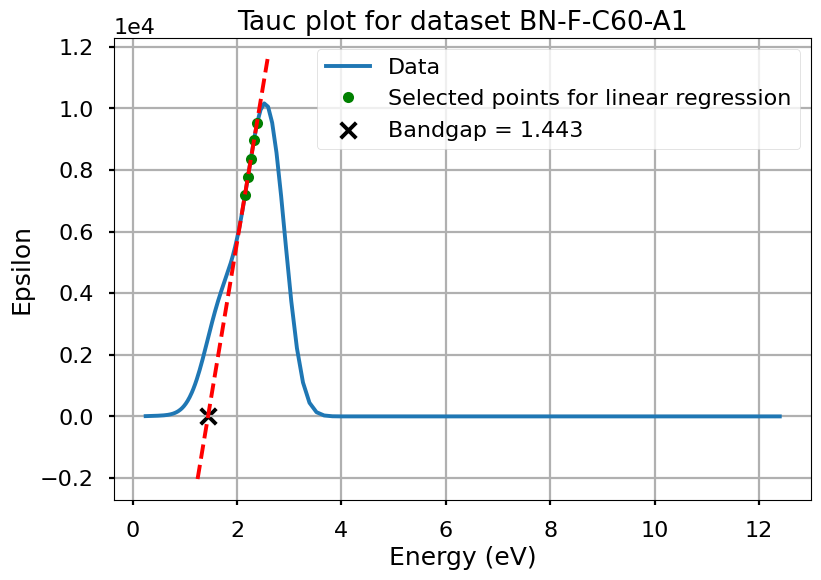

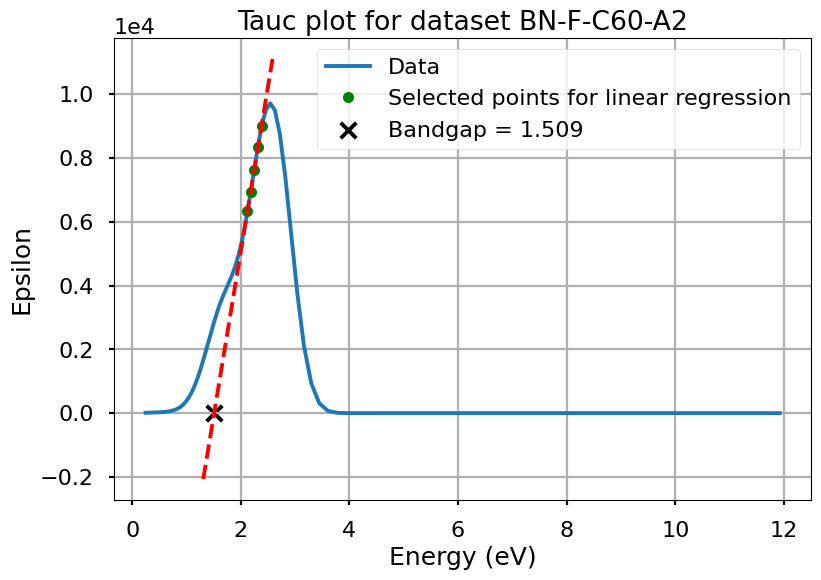

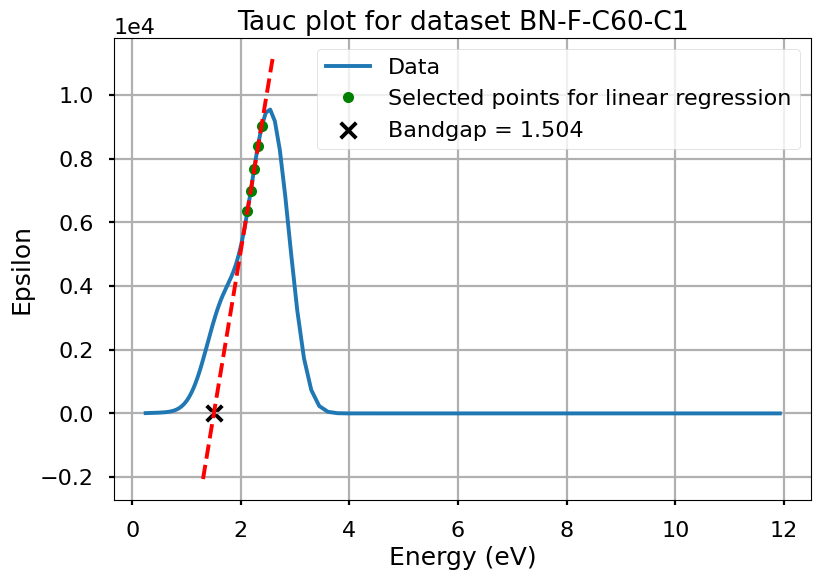

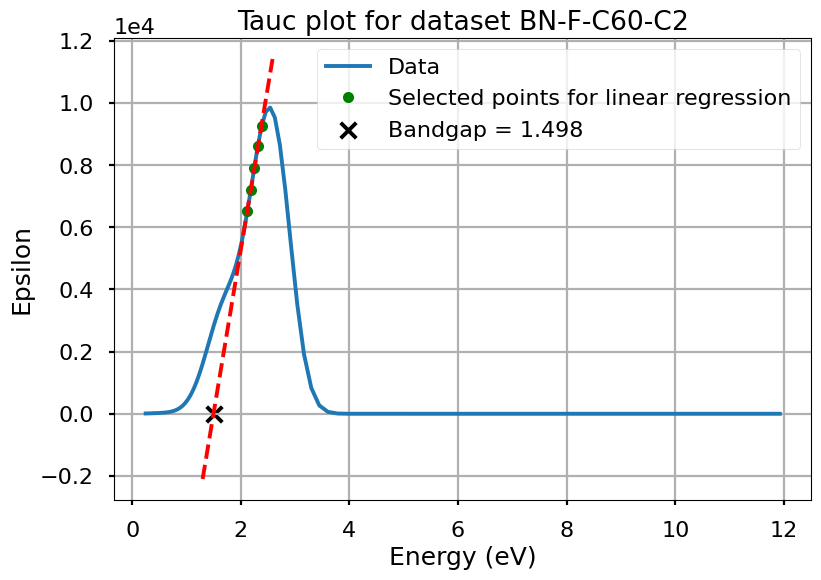

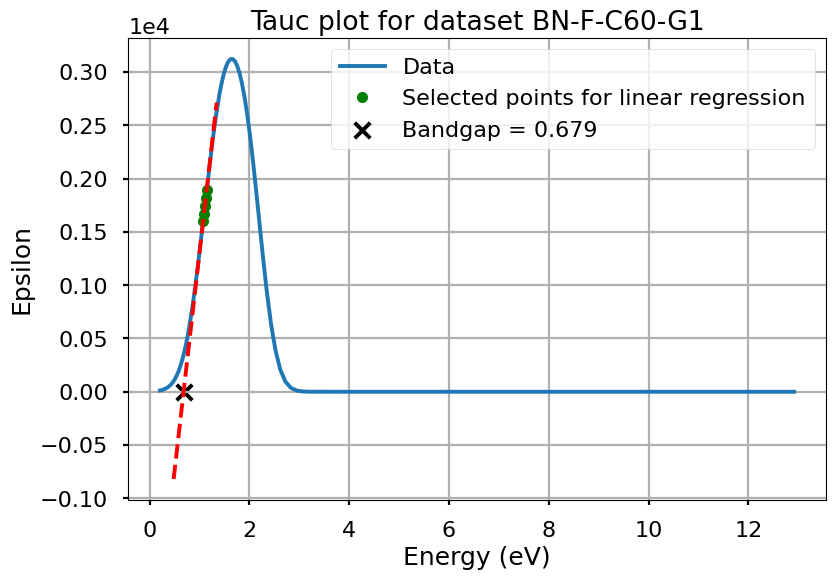

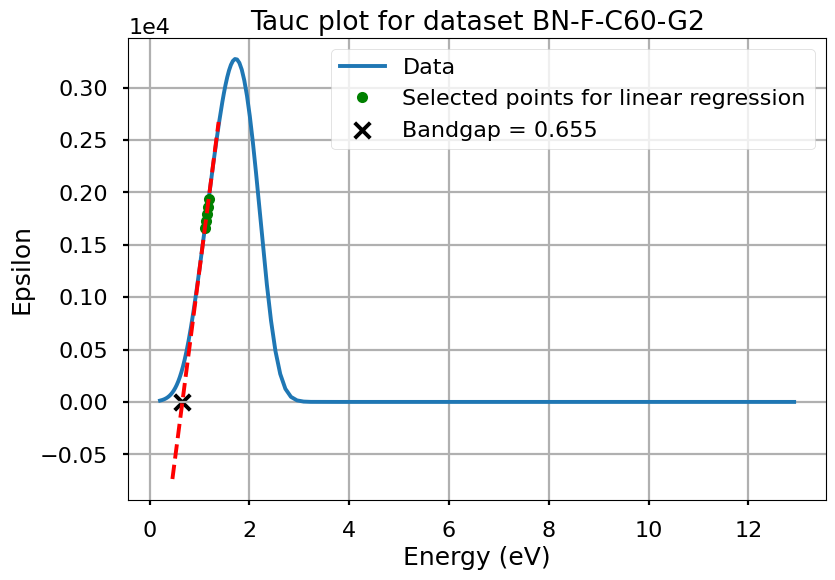

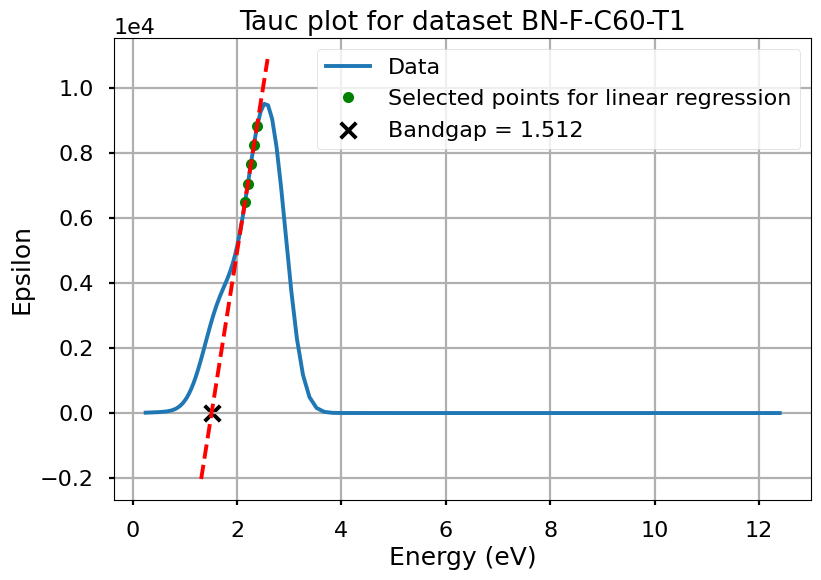

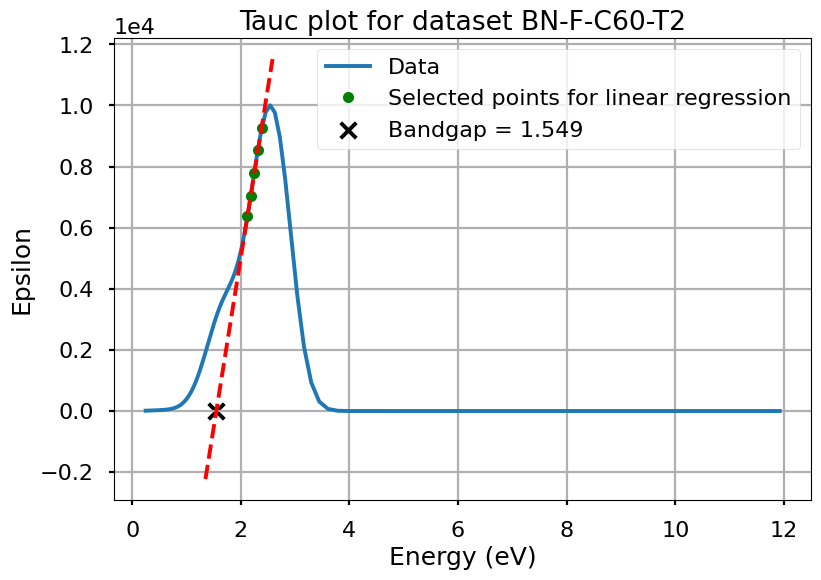

In [10]:
# Check the code
# Calculating optical band gaps for each functional
bandgaps = {}
selected_points = {}

for key in data_all:

    data = data_all[key]
    # Convert energy units from nm (nanometers) to eV (electron volts)
    x = 1240 / data[:,0]
    y = data[:,1]

    # Reverse arrays using sorting.
    # Sort testing data by x values and rearrange corresponding y values
    x_sorted_indices = x.argsort()
    y = y[x_sorted_indices]
    x = x[x_sorted_indices]
    
    bandgaps[key], selected_points[key] = calculate_bandgap(x, y, key, neighbor_size, img_folder+"/bandgap_input_data/", True)
    data= []

In [11]:
# Optical badgaps for the datasets
for key in bandgaps:
    bandgap = bandgaps[key]
    print(key,  "\t%.3f" % bandgap)

C60 	3.265
BN-C60 	1.226
BN-F-C60 	1.609
BN-F-C60-A1 	1.443
BN-F-C60-A2 	1.509
BN-F-C60-C1 	1.504
BN-F-C60-C2 	1.498
BN-F-C60-G1 	0.679
BN-F-C60-G2 	0.655
BN-F-C60-T1 	1.512
BN-F-C60-T2 	1.549


## Regression

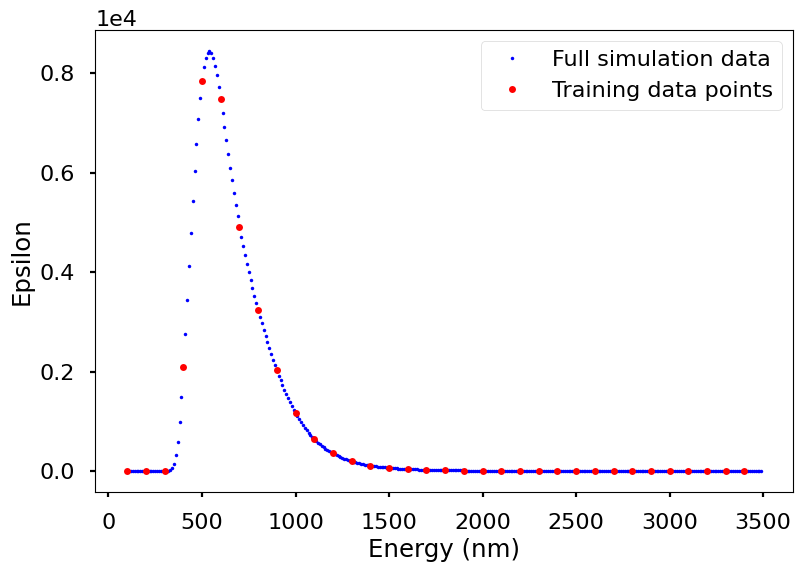

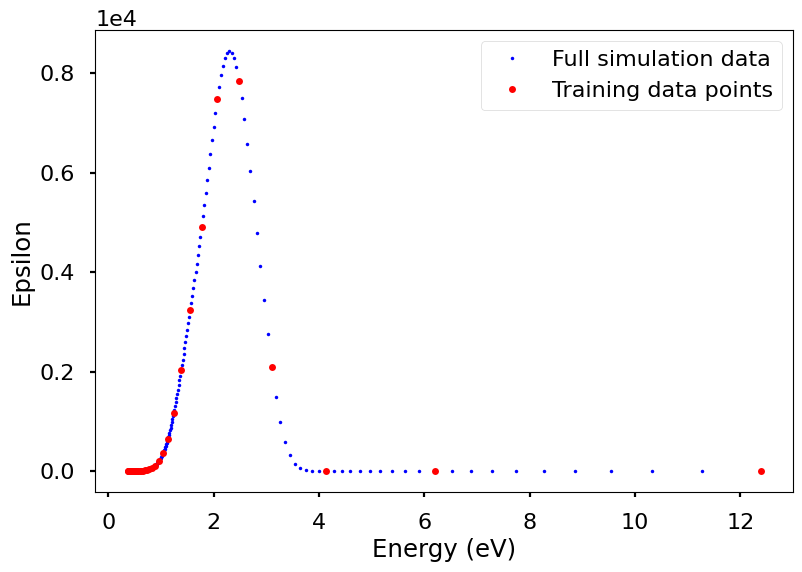

In [12]:
# Show an example for data point selection.
dataset_name =  'BN-C60'
data = data_all[dataset_name]

X_full = data[:,0]
y_full = data[:,1]

step_length = 10

X_train, y_train, X_test, y_test = prepare_train_test_dataset(X_full, y_full, step_length, plot = True)

In [13]:
for step_length in step_lengths:

        gpr_bandgaps = {}
        gpr_selected_point = {}
        gpr_sigma = {}
        results = {}

        print("\nStep length: ", step_length)
        
        for key in data_all:
                data = data_all[key]

                print(" ",key," ", end="")

                X_full = data[:,0]
                y_full = data[:,1]

                X_train, y_train, X_test, y_test = prepare_train_test_dataset(X_full, y_full, step_length, plot=False)

                # Initialize the MinMaxScaler (default feature_range is (0, 1))
                scaler = MinMaxScaler()

                y_train = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test = scaler.transform(y_test.reshape(-1, 1)).ravel()

                # Kernel: composed of a constant term and an RBF term for smoothness
                kernel = C(0.1, (1e-4, 1e1)) * RBF(0.1, (1e-4, 1e1))

              
                # Create GaussianProcessRegressor object
                gpr = GaussianProcessRegressor(kernel=kernel, alpha=1e-5, n_restarts_optimizer=10, random_state=32)


                # Fit to data
                gpr.fit(X_train, y_train)

                # save the model to disk
                model_name = "./models/" + key + "_stepSize_" + str(step_length) + ".pkl"
                with open(model_name,'wb') as myfile:
                      pickle.dump(gpr,myfile) 

                # Making predictions
                y_pred, sigma = gpr.predict(X_test, return_std=True)
                gpr_sigma[key] = sigma


                # Calculate error metrics
                mae = mean_absolute_error(y_test, y_pred)
                mse = mean_squared_error(y_test, y_pred)
                rmse = np.sqrt(mse)
                
                r2 = r2_score(y_test, y_pred)
                

                # Print the errors
                #print(f'Mean Absolute Error: {mae}')
                #print(f'Mean Squared Error: {mse}')
                #print(f'Root Mean Squared Error: {rmse}')
                #print(f'$R^2  Score: {"%.4f" % r2}$')

                gpr_bandgaps[key], gpr_selected_point[key] = calculate_bandgap(X_test.flatten(), scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel(), key+'_'+str(step_length), neighbor_size,  img_folder+"/bandgap_gpr_results/", plot=False)

                results[key] = [mae, mse, rmse, r2, gpr_bandgaps[key]]

        results_all[str(step_length)] = results



Step length:  5
  C60    BN-C60    BN-F-C60    BN-F-C60-A1    BN-F-C60-A2    BN-F-C60-C1    BN-F-C60-C2    BN-F-C60-G1    BN-F-C60-G2    BN-F-C60-T1    BN-F-C60-T2  
Step length:  10
  C60    BN-C60    BN-F-C60    BN-F-C60-A1    BN-F-C60-A2    BN-F-C60-C1    BN-F-C60-C2    BN-F-C60-G1    BN-F-C60-G2    BN-F-C60-T1    BN-F-C60-T2  
Step length:  15
  C60    BN-C60    BN-F-C60    BN-F-C60-A1    BN-F-C60-A2    BN-F-C60-C1    BN-F-C60-C2    BN-F-C60-G1    BN-F-C60-G2    BN-F-C60-T1    BN-F-C60-T2  
Step length:  20
  C60    BN-C60    BN-F-C60    BN-F-C60-A1    BN-F-C60-A2    BN-F-C60-C1    BN-F-C60-C2    BN-F-C60-G1    BN-F-C60-G2    BN-F-C60-T1    BN-F-C60-T2  

In [14]:
print("Optimizer: ", gpr.optimizer)

Optimizer:  fmin_l_bfgs_b


## Test Results

In [15]:
# Mean Absolute Error
i=0 
for key in results_all[str(10)]:
    for step_length in step_lengths:
        print("%.4f\t" % results_all[str(step_length)][key][i], end = '')
    print()

0.0002	0.0009	0.0046	0.0083	
0.0008	0.0033	0.0087	0.0236	
0.0012	0.0020	0.0083	0.0555	
0.0007	0.0040	0.0123	0.0402	
0.0009	0.0106	0.0208	0.0265	
0.0011	0.0102	0.0202	0.0303	
0.0011	0.0098	0.0192	0.0282	
0.0016	0.0045	0.0051	0.0029	
0.0013	0.0027	0.0086	0.0077	
0.0008	0.0036	0.0096	0.0482	
0.0009	0.0111	0.0217	0.0281	


In [16]:
i=1 # Mean Squared Error
for key in results_all[str(10)]:
    for step_length in step_lengths:
        print("%.4f\t" % results_all[str(step_length)][key][i], end = '')
    print()

0.0000	0.0000	0.0001	0.0005	
0.0000	0.0002	0.0009	0.0073	
0.0000	0.0001	0.0014	0.0677	
0.0000	0.0004	0.0037	0.0376	
0.0000	0.0020	0.0078	0.0098	
0.0000	0.0018	0.0071	0.0130	
0.0000	0.0017	0.0059	0.0113	
0.0001	0.0004	0.0006	0.0001	
0.0000	0.0001	0.0015	0.0009	
0.0000	0.0003	0.0021	0.0519	
0.0000	0.0022	0.0084	0.0110	


In [17]:
i=2 # Root Mean Squared Error
for key in results_all[str(10)]:
    for step_length in step_lengths:
        print("%.4f\t" % results_all[str(step_length)][key][i], end = '')
    print()

0.0004	0.0025	0.0116	0.0227	
0.0029	0.0131	0.0303	0.0853	
0.0062	0.0109	0.0370	0.2602	
0.0033	0.0202	0.0606	0.1940	
0.0048	0.0444	0.0883	0.0988	
0.0061	0.0428	0.0843	0.1141	
0.0060	0.0411	0.0767	0.1064	
0.0095	0.0198	0.0247	0.0108	
0.0063	0.0102	0.0382	0.0308	
0.0039	0.0178	0.0459	0.2278	
0.0049	0.0464	0.0916	0.1047	


In [18]:
# R^2 Score
i=3 
for key in results_all[str(10)]:
    for step_length in step_lengths:
        print("%.4f\t" % results_all[str(step_length)][key][i], end = '')
    print()

1.0000	0.9999	0.9977	0.9940	
0.9998	0.9974	0.9838	0.8881	
0.9989	0.9970	0.9653	0.6222	
0.9997	0.9892	0.9028	0.7279	
0.9993	0.9743	0.8982	0.8971	
0.9989	0.9752	0.9039	0.8884	
0.9989	0.9770	0.9200	0.8943	
0.9986	0.9941	0.9926	0.9982	
0.9993	0.9985	0.9801	0.9861	
0.9996	0.9916	0.9445	0.6580	
0.9993	0.9724	0.8924	0.8854	


In [22]:
# Optical Band Gap on predicted data
i=4
for key in results_all[str(10)]:
    #print("%.4f\t" % bandgaps[key], end = '')
    for step_length in step_lengths:
        print("%.3f\t" % results_all[str(step_length)][key][i], end = '')
    print("%.3f\t" % bandgaps[key], end = '')
    print()

3.267	3.266	3.253	3.226	3.265	
1.217	1.218	1.143	1.127	1.226	
1.608	1.599	1.420	1.052	1.609	
1.440	1.456	1.279	1.075	1.443	
1.512	1.156	1.105	1.089	1.509	
1.505	1.138	1.100	1.069	1.504	
1.499	1.170	1.111	1.082	1.498	
0.679	0.680	0.680	0.682	0.679	
0.660	0.668	0.666	0.674	0.655	
1.511	1.532	1.363	1.045	1.512	
1.551	1.208	1.105	1.085	1.549	


# Visualization

C60


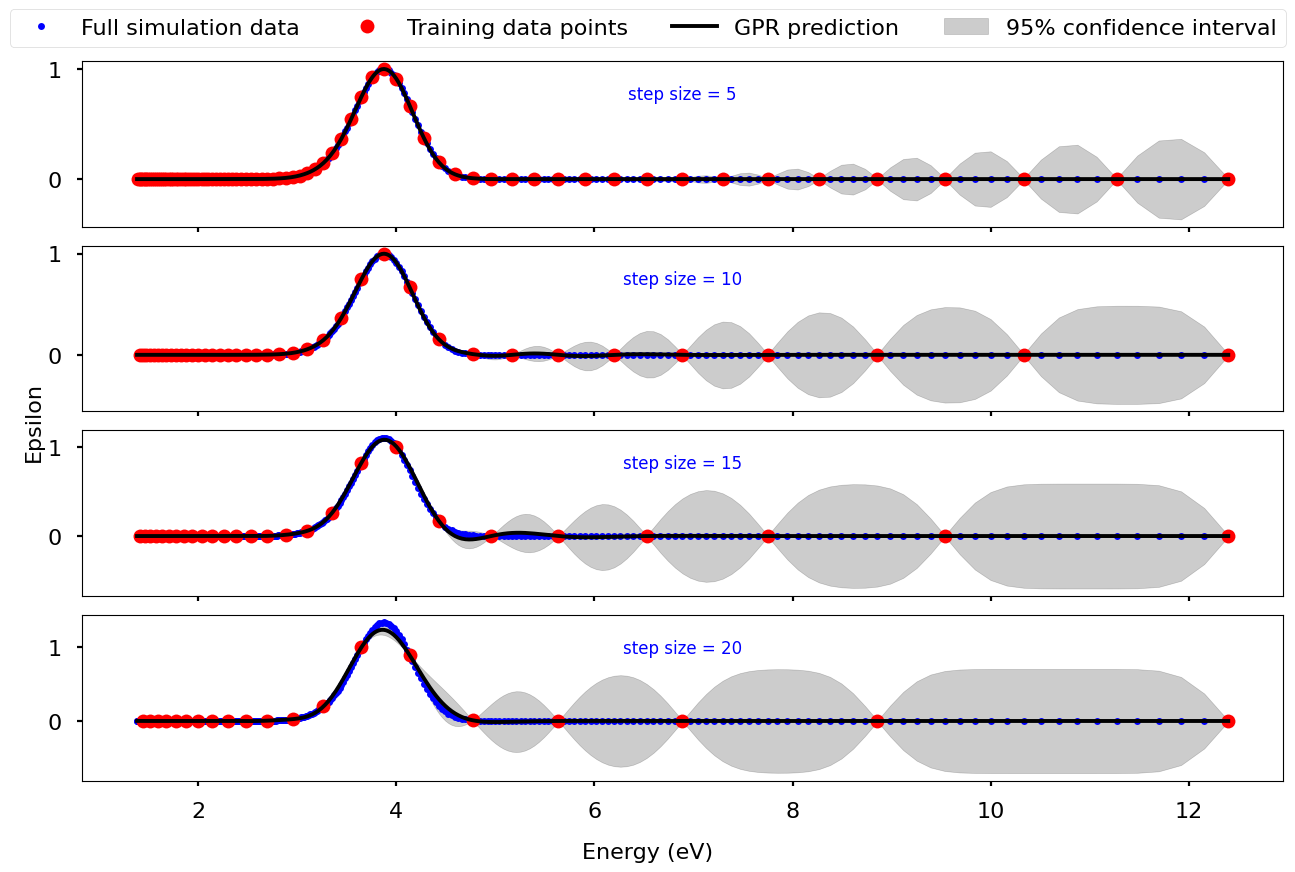

BN-C60


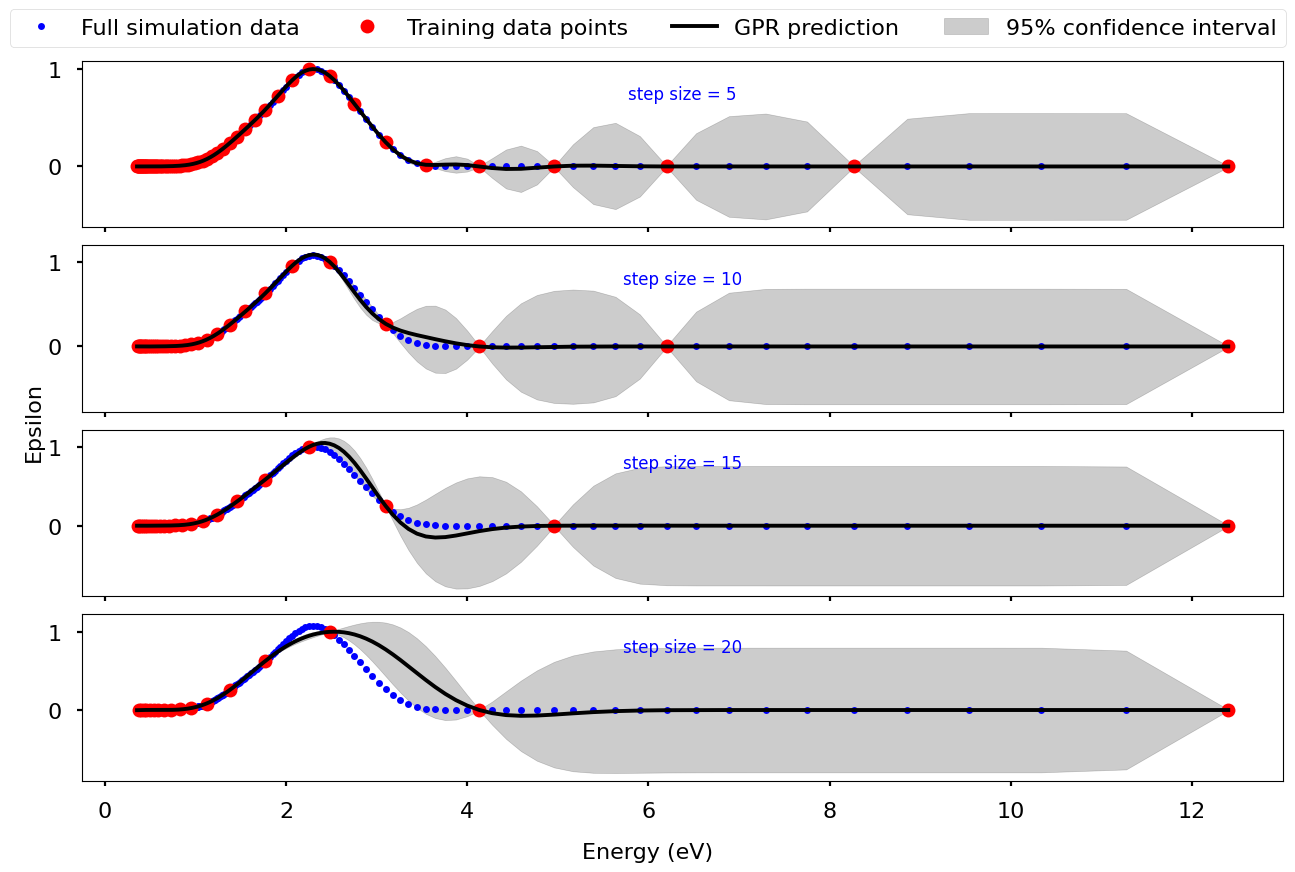

BN-F-C60


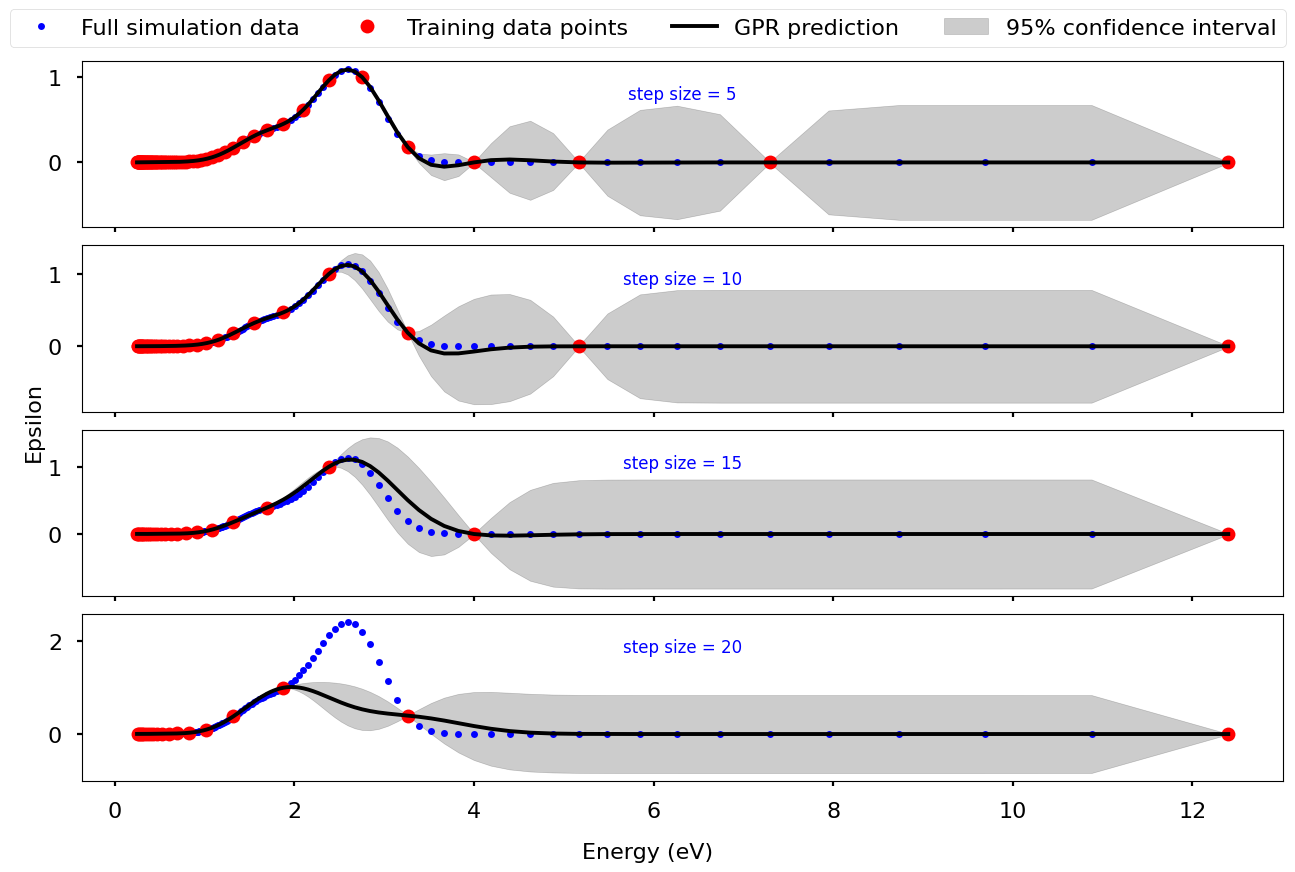

BN-F-C60-A1


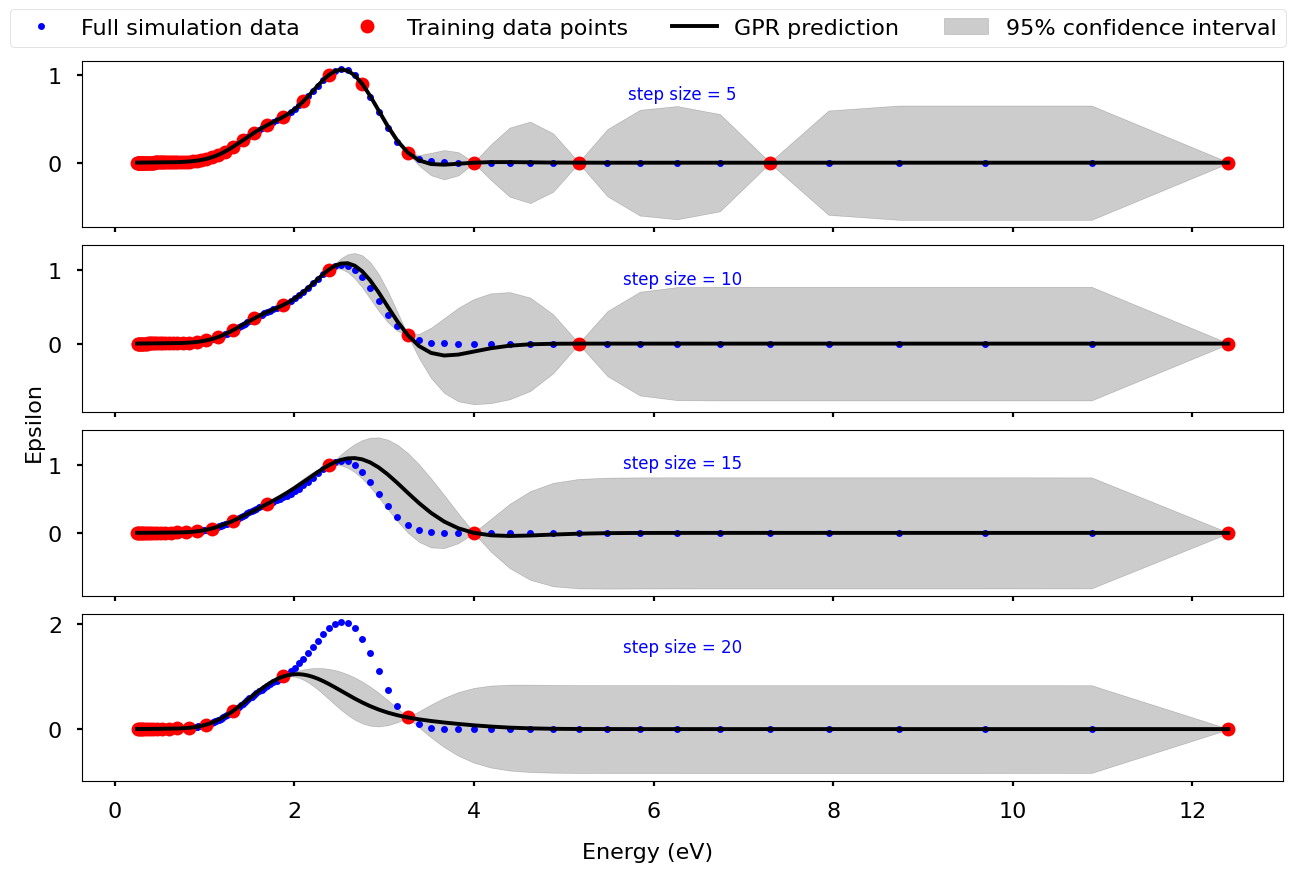

BN-F-C60-A2


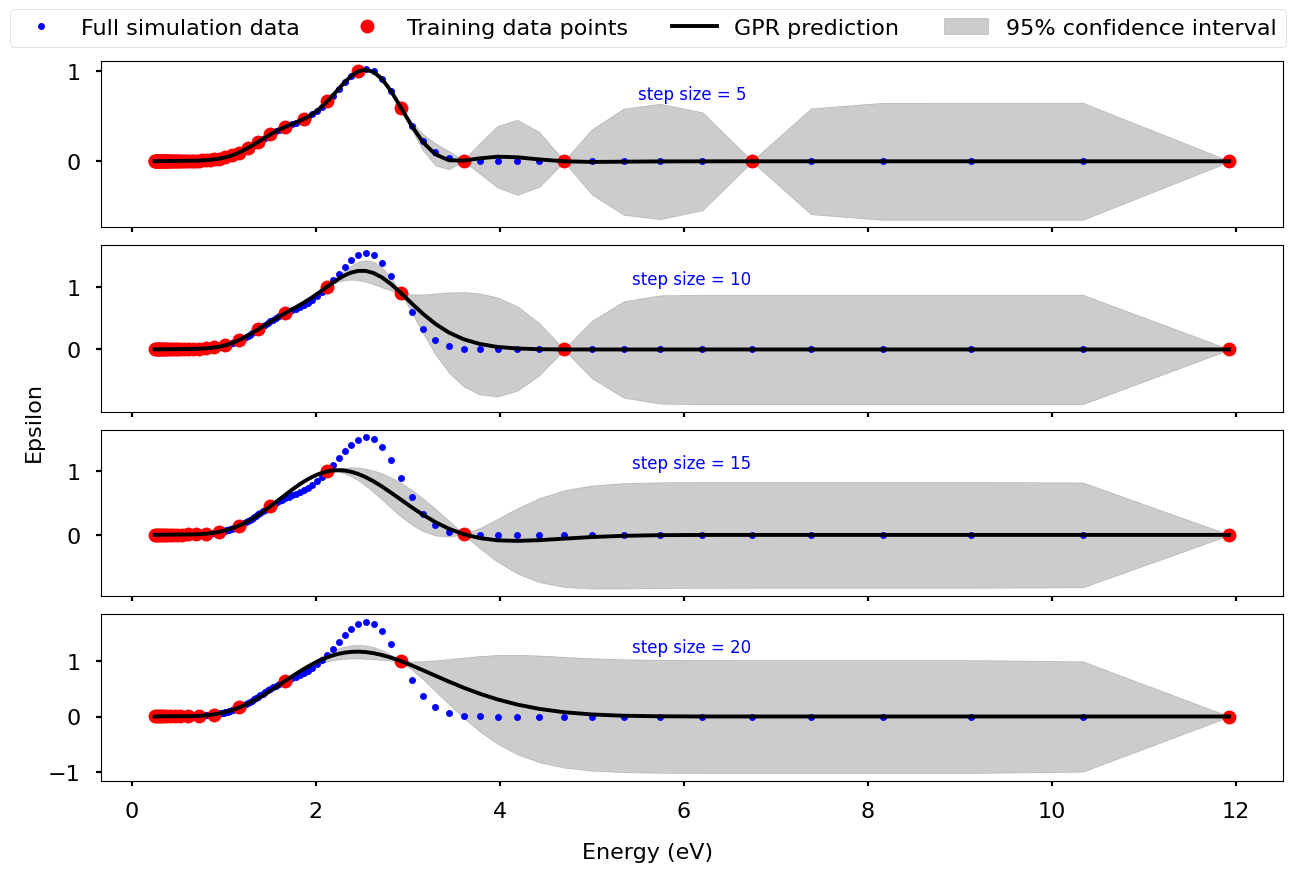

BN-F-C60-C1


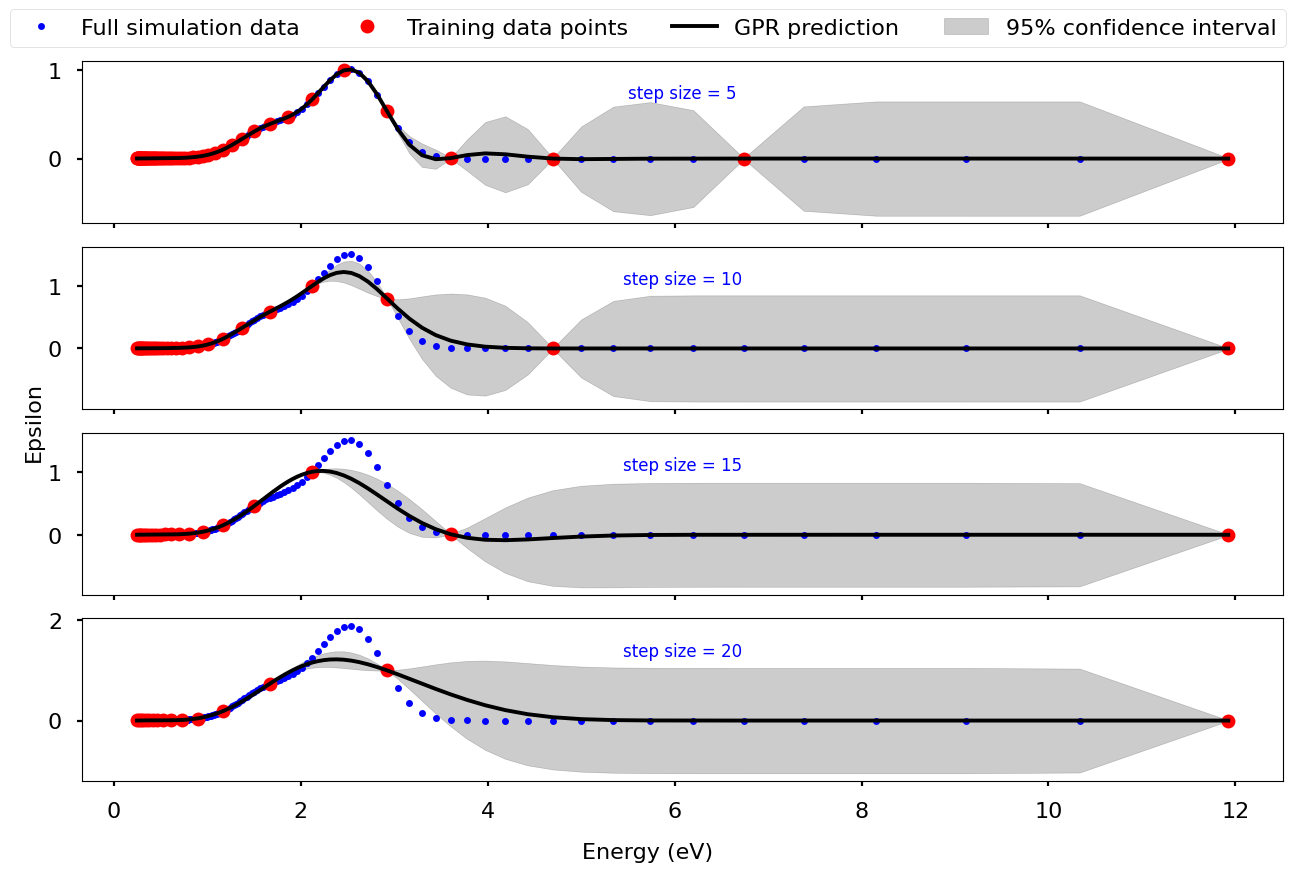

BN-F-C60-C2


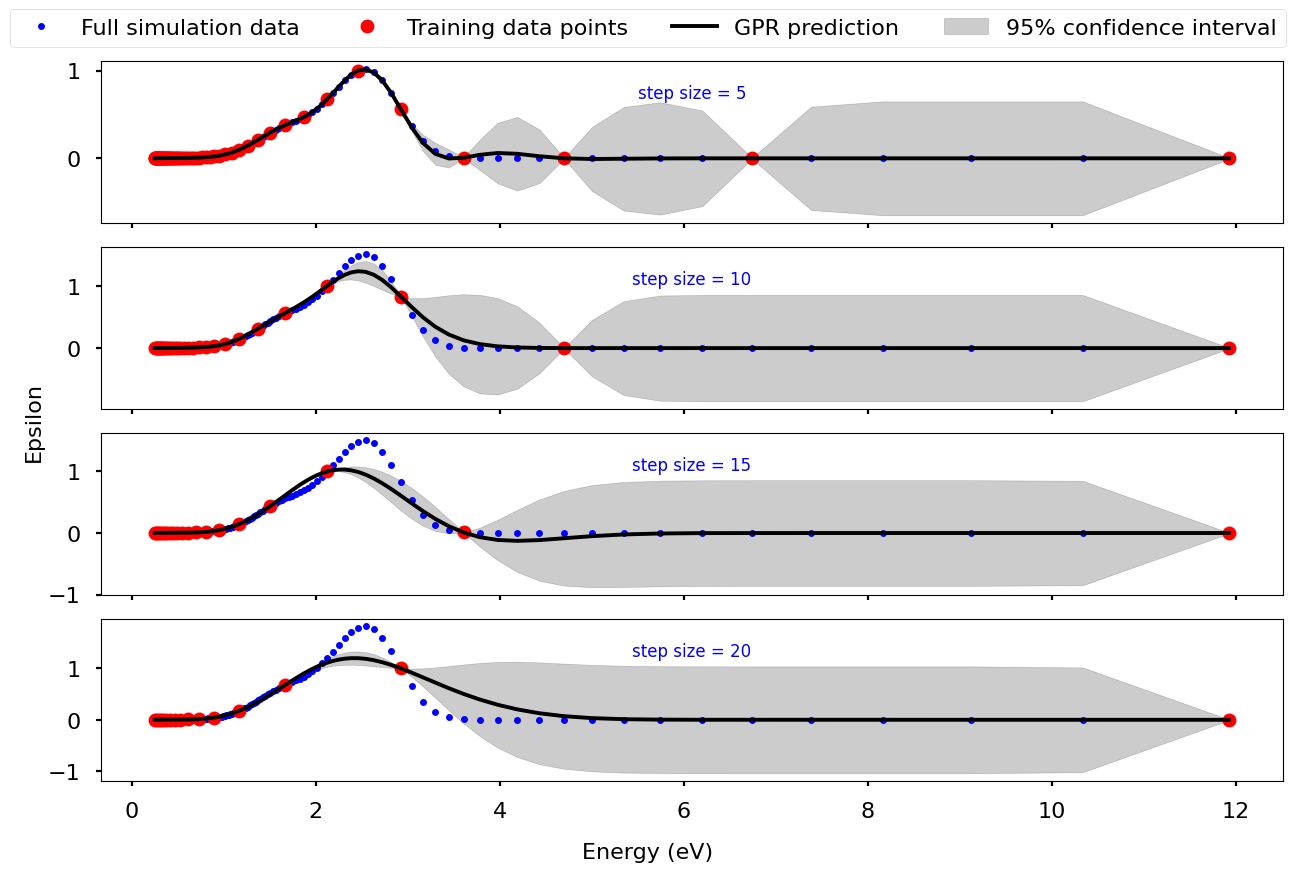

BN-F-C60-G1


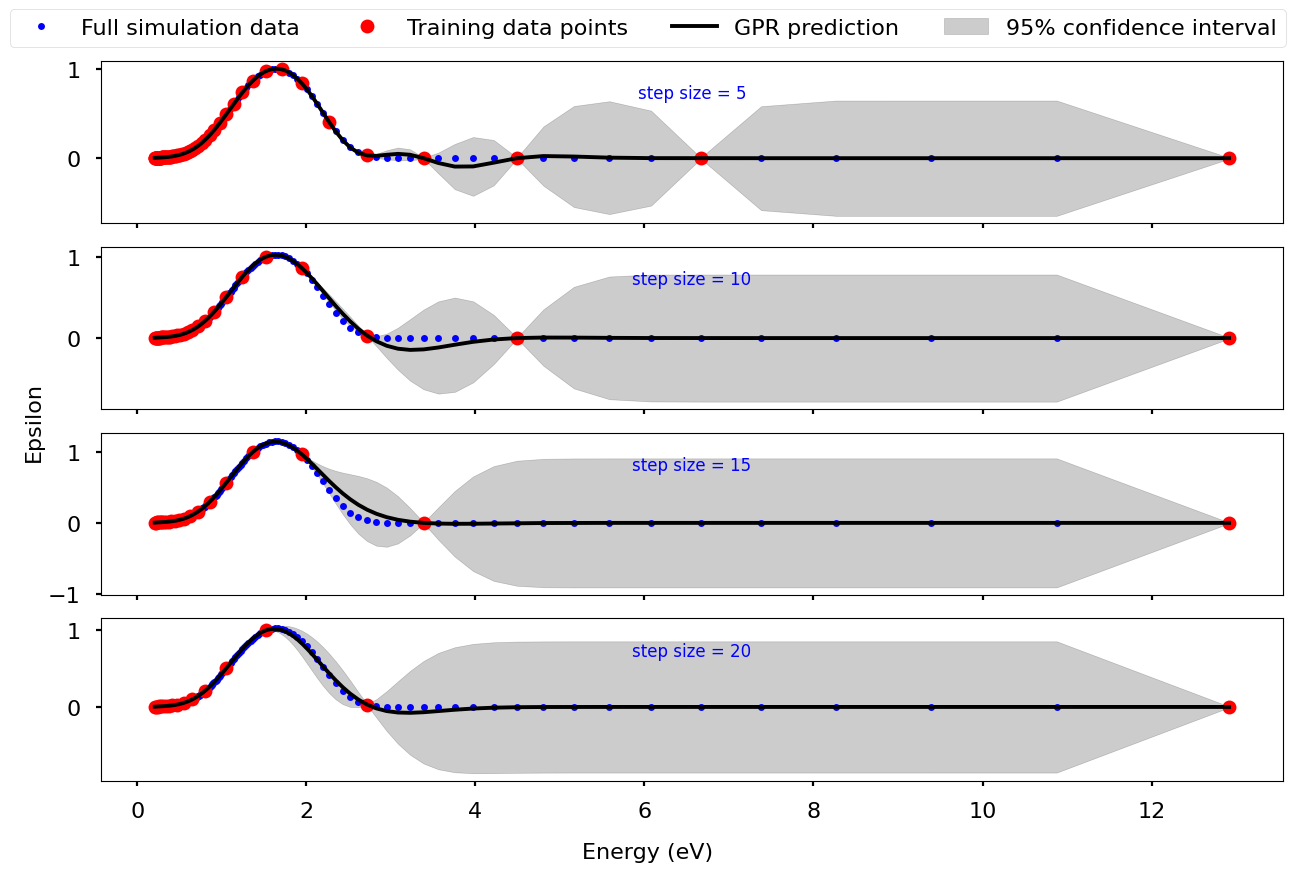

BN-F-C60-G2


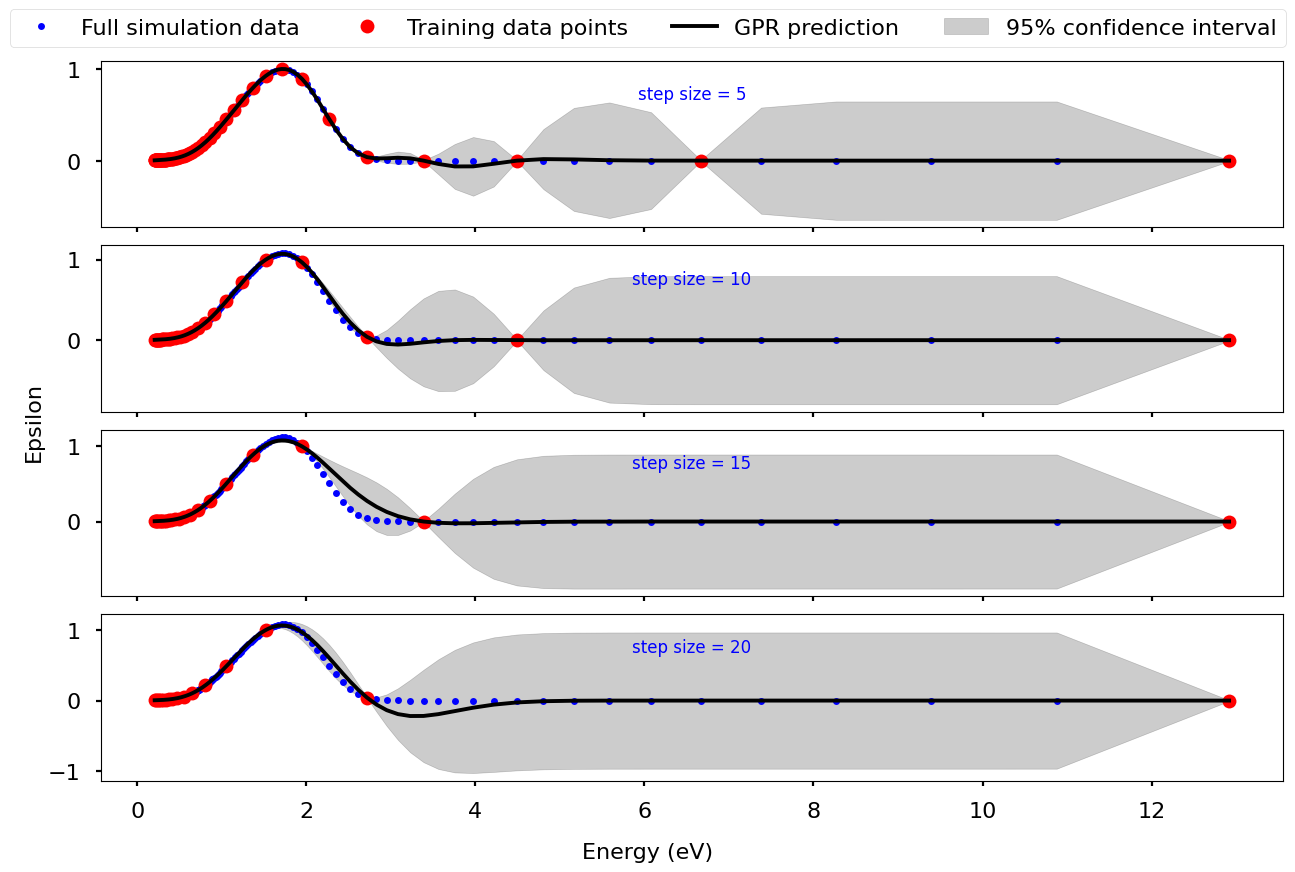

BN-F-C60-T1


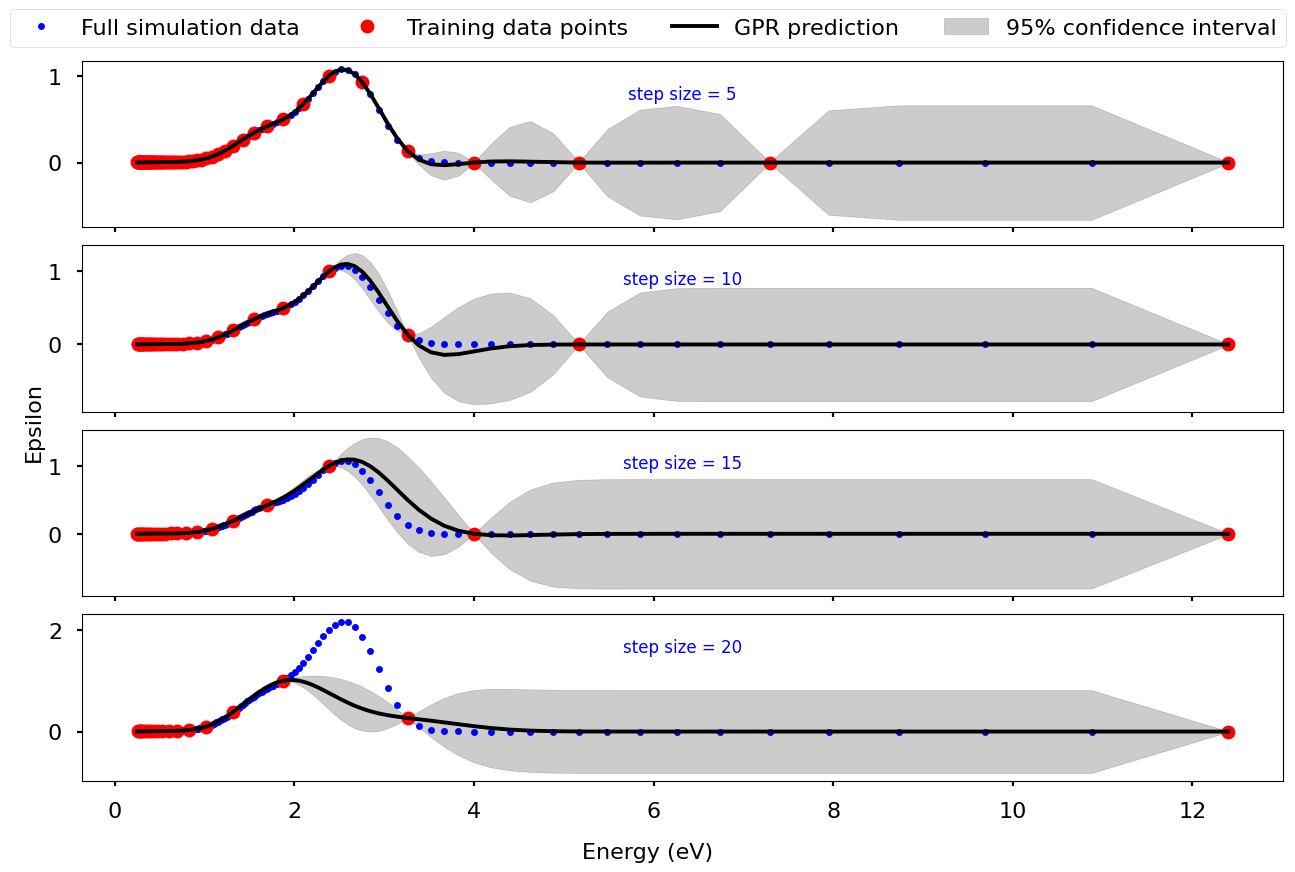

BN-F-C60-T2


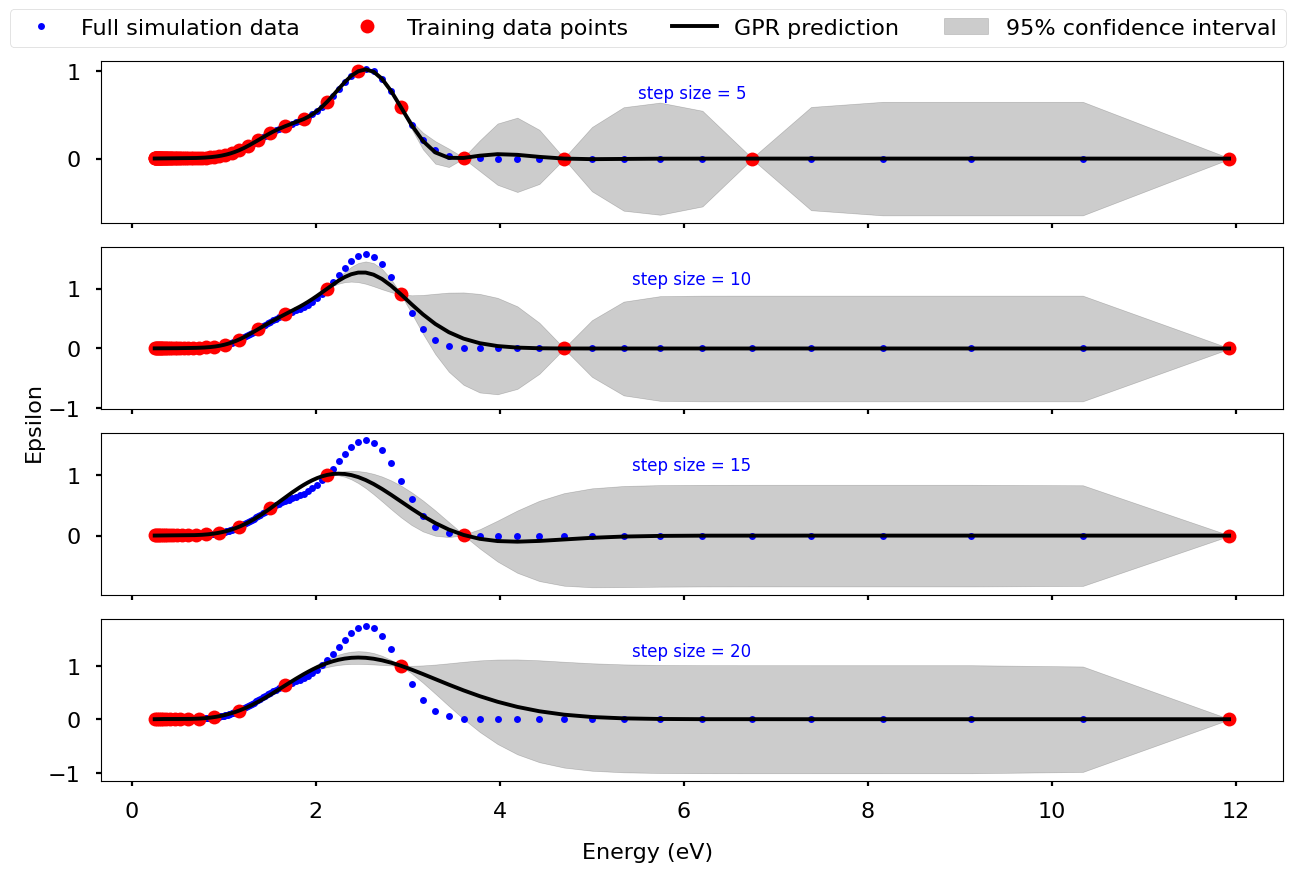

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8-poster')

for key in data_all:
        i = 0
        # Create a figure with subplots

        fig, axes = plt.subplots(nrows=len((step_lengths)), ncols=1, figsize=(13, 9))  # Adjust the figsize as needed
        print(key)
        for idx, step_length in enumerate(step_lengths):


                data = data_all[key]

                X_full = data[:,0]
                y_full = data[:,1]

                X_train, y_train, X_test, y_test = prepare_train_test_dataset(X_full, y_full, step_length, plot=False)

                # Initialize the MinMaxScaler (default feature_range is (0, 1))
                scaler = MinMaxScaler()

                y_train = scaler.fit_transform(y_train.reshape(-1, 1)).ravel()
                y_test = scaler.transform(y_test.reshape(-1, 1)).ravel()

                # load the model
                model_name = "./models/" + key + "_stepSize_" + str(step_length) + ".pkl"
                with open(model_name,'rb') as myfile:
                        gpr = pickle.load(myfile) 

                # Making predictions
                #x_pred = np.linspace(min(x), max(x), 100).reshape(-1, 1)
                y_pred, sigma = gpr.predict(X_test, return_std=True)
                #gpr_sigma[key] = sigma


                # Plotting
                axes[idx].plot(X_test, y_test, 'b.', markersize=10, label='Full simulation data')
                axes[idx].plot(X_train, y_train, 'ro', markersize=10, label='Training data points')

                axes[idx].plot(X_test, y_pred, 'k-', label='GPR prediction')
                axes[idx].fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='k', label='95% confidence interval')

                axes[idx].text(0.5, 0.80, 'step size = ' + str(step_length), transform=axes[idx].transAxes, ha='center', va='center', fontsize=12, color='blue')


                # Hide x-axis labels for all but the last subplot
                if idx < len(step_lengths)-1:  # If it's not the last subplot
                        axes[idx].set_xticklabels([])  # Hide x-axis labels

        # Adding a common x-axis and y-axis title
        fig.supxlabel('Energy (eV)', fontsize=16, color='black')
        fig.supylabel('Epsilon', fontsize=16, color='black')

        handles, labels = axes[idx].get_legend_handles_labels()
        fig.legend(handles, labels,  loc='upper center', bbox_to_anchor=(0.5, 0.97), ncol=4)

        plt.tight_layout()
        plt.subplots_adjust(top=0.90)  # Adjust this based on the size of your title and legend

        #plt.savefig('HighResPlot.png', dpi=300)  # Save as PNG with high DPI
        #plt.savefig(key +'.svg', format='svg')  # Save as SVG for vector graphics
        plt.savefig(img_folder+'/gpr/' + key + '.png', bbox_inches='tight')

        plt.show()
        plt.close()

